# TP53 trans effect histograms for all proteins


This notebook analyzes the trans effect of TP53 mutation for all proteins.

### Library Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import gseapy as gp
from gseapy.plot import barplot, dotplot

import warnings
warnings.filterwarnings("ignore")

import cptac
import cptac.utils as al

In [2]:
brain = cptac.Gbm()

### Specify Gene

In [3]:
gene = "TP53"

# Transcriptomics: All Proteins

In [4]:
transcrpt = "transcriptomics"

try:
    print("\nGene: ", gene)

    #Use all proteins

    #Create dataframe in order to do comparisons with wrap_ttest
    transcrpt_df = brain.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=transcrpt)
    transcrpt_df = brain.reduce_multiindex(transcrpt_df, flatten=True)
    transcrpt_df = transcrpt_df[transcrpt_df.Sample_Status == 'Tumor'] # drop Normal samples
    #Remove Cis interactions 
    transcrpt_df = transcrpt_df.loc[:,~transcrpt_df.columns.str.contains(gene+'_transcriptomics')] # change for each gene 
    transcrpt_df = transcrpt_df.dropna(axis=1, how='all') # drop columns with all NaN data
    
    #Create the binary valued column needed to do the comparison
    for ind, row in transcrpt_df.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            transcrpt_df.at[ind,'Label'] = 'Mutated'
        else:
            transcrpt_df.at[ind,'Label'] = 'Wildtype'

    #Format the datafram correctly
    transcrpt_df = transcrpt_df.drop(gene+"_Mutation",axis=1)
    transcrpt_df = transcrpt_df.drop(gene+"_Location",axis=1)
    transcrpt_df = transcrpt_df.drop(gene+"_Mutation_Status", axis=1)
    transcrpt_df = transcrpt_df.drop("Sample_Status",axis=1)

    #Make list of columns to be compared using t-tests
    t_col_list = list(transcrpt_df.columns)
    t_col_list.remove('Label')

    print("Doing t-test comparisons\n")
    
    #Call wrap_ttest, pass in formatted dataframe
    transcrpt_all_comparisons = al.wrap_ttest(transcrpt_df, 'Label', t_col_list, return_all=True)

    t_num_comparisons = len(t_col_list)
    print("Number of comparisons:", t_num_comparisons)
    t_bonferroni_cutoff = .05 / t_num_comparisons
    print("Bonferroni cutoff = ", t_bonferroni_cutoff)
    print("Logged Bonferroni cutoff = ", np.log10(t_bonferroni_cutoff))

except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  TP53


Doing t-test comparisons

11 significant comparisons!
Number of comparisons: 60482
Bonferroni cutoff =  8.266922390132602e-07
Logged Bonferroni cutoff =  -6.0826561395096865


Transcriptomics: Print Significant Comparisons

In [5]:
transcrpt_all_comparisons = transcrpt_all_comparisons.dropna(axis=0)
transcrpt_sig_comparisons = transcrpt_all_comparisons.loc[transcrpt_all_comparisons['P_Value'] <= t_bonferroni_cutoff]
print("Number of significant comparisons for Transcriptomics: ", len(transcrpt_sig_comparisons))
transcrpt_sig_comparisons

Number of significant comparisons for Transcriptomics:  11


,Comparison,P_Value
0,AEN_transcriptomics_ENSG00000181026.14,8.562056e-10
1,EDA2R_transcriptomics_ENSG00000131080.13,8.800930e-10
2,DDB2_transcriptomics_ENSG00000134574.10,1.176977e-08
3,PHLDA3_transcriptomics_ENSG00000174307.6,3.052271e-08
4,DRG2_transcriptomics_ENSG00000108591.8,8.233337e-08
5,RP11-37C7.2_transcriptomics_ENSG00000259432.1,1.002485e-07
6,CDKN2A_transcriptomics_ENSG00000147889.15,1.127793e-07
7,DCAF12_transcriptomics_ENSG00000198876.11,1.445258e-07
8,ZFAT_transcriptomics_ENSG00000066827.14,1.489154e-07
9,GPR176_transcriptomics_ENSG00000166073.7,1.589371e-07


Transcriptomics: Histogram for all proteins

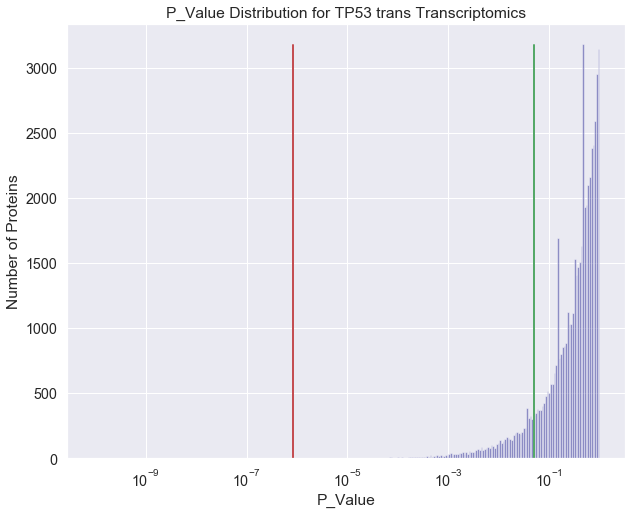

In [6]:
# Create series of p-values for Histogram
transcrpt_pval_series = transcrpt_all_comparisons['P_Value']

# Format figure size and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
t_log_min, t_log_max = np.log10(transcrpt_pval_series.min()), np.log10(transcrpt_pval_series.max())
t_bins = np.logspace(t_log_min - 1, t_log_max, 300) # change bin number here
histogram = sns.distplot(transcrpt_pval_series, bins = t_bins, kde=False, color='navy') 

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Transcriptomics")
histogram.set(ylabel = 'Number of Proteins')
#plt.xlim([10e-9,10e-1])
#plt.ylim([0, 3500]) # change y-axis range

# Graph cutoffs: alpha = green, bonferroni = red
plt.axvline(t_bonferroni_cutoff, 0, 0.95, linewidth=2, color='r')
plt.axvline(0.05, 0, 0.95, linewidth=2, color='g')

plt.show()
plt.clf()
plt.close()

Transcriptomics zoomed in

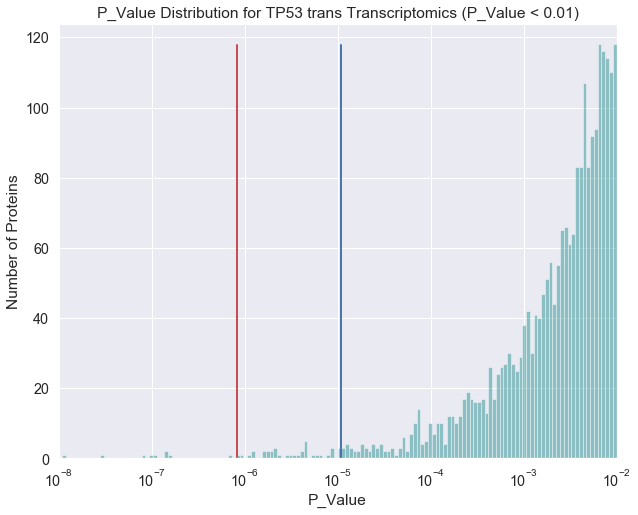

In [7]:
# Select p-values within range 0 - end_value 
t_end_value = 0.01
transcrpt_zoomed = transcrpt_pval_series.loc[transcrpt_pval_series <= t_end_value]

# Format size of figure and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
t_zoomed_log_min, t_zoomed_log_max = np.log10(transcrpt_zoomed.min()),np.log10(transcrpt_zoomed.max())
t_zoomed_bins = np.logspace(t_zoomed_log_min - 1, t_zoomed_log_max, 200) # change this number for more or less bins
histogram = sns.distplot(transcrpt_zoomed, bins=t_zoomed_bins, kde=False, color='teal')

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Transcriptomics (P_Value < " + str(t_end_value) + ")")
histogram.set(ylabel = 'Number of Proteins')
plt.xlim([10e-9,10e-3])
#plt.ylim([0.0,400]) # change y axis intervals

# Create bonferroni cutoff line 
plt.axvline(t_bonferroni_cutoff, 0, .95, linewidth=2, color='r') # cutoff line parameters: (cutoff, 0, height)

# Create extended cutoff line 
plt.axvline(t_bonferroni_cutoff + .00001, 0, .95, linewidth=2, color='b') # cutoff line parameters: (cutoff, 0, height)

plt.show()
plt.clf()
plt.close()

In [8]:
# 50 genes
t_gsea = transcrpt_all_comparisons.sort_values(by = 'P_Value')
t_first_fifty = t_gsea.iloc[:50]
print("Number of Transcriptomics comparisons for gsea: ", len(t_first_fifty))

# create gene list
t_genes = t_first_fifty['Comparison']
t_genes.replace(to_replace = '_transcriptomics.*$', value = '', 
                        inplace = True, regex = True) # shorten column names
t_genes.replace(to_replace = '-.*$', value = '', 
                        inplace = True, regex = True) # shorten column names
t_genes_list = list(t_genes)

t_enr = gp.enrichr(gene_list = t_genes_list, description='Transcriptomics_Comparisons', gene_sets='KEGG_2016', 
                       outdir='Enrichment Analysis')

t_enr.res2d.head()

Number of Transcriptomics comparisons for gsea:  50


2019-10-14 15:04:07,545 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.05


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,p53 signaling pathway_Homo sapiens_hsa04115,3/69,0.000354,0.103821,0,0,21.739130,172.723087,CDKN2A;GORAB;DDB2,KEGG_2016
1,Prion diseases_Homo sapiens_hsa05020,1/35,0.067727,1.000000,0,0,14.285714,38.461025,C5,KEGG_2016
2,Bladder cancer_Homo sapiens_hsa05219,1/41,0.078879,1.000000,0,0,12.195122,30.973634,CDKN2A,KEGG_2016
3,Cysteine and methionine metabolism_Homo sapien...,1/45,0.086242,1.000000,0,0,11.111111,27.228911,MTAP,KEGG_2016
4,Nucleotide excision repair_Homo sapiens_hsa03420,1/47,0.089901,1.000000,0,0,10.638298,25.628111,DDB2,KEGG_2016


# Proteomics: All Proteins

In [9]:
prot = "proteomics"

try:
    print("\nGene: ", gene)

    #Use all proteins

    #Create dataframe in order to do comparisons with wrap_ttest
    protdf = brain.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=prot)
    protdf = brain.reduce_multiindex(protdf, flatten=True)
    protdf = protdf[protdf.Sample_Status == 'Tumor'] # drop Normal samples
    
    #Remove Cis interactions 
    protdf = protdf.drop(columns = gene+"_proteomics") # change for each gene 
    protdf = protdf.dropna(axis=1, how='all') # drop columns with all NaN data
    
    #Create the binary valued column needed to do the comparison
    for ind, row in protdf.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            protdf.at[ind,'Label'] = 'Mutated'
        else:
            protdf.at[ind,'Label'] = 'Wildtype'

    #Format the datafram correctly
    protdf = protdf.drop(gene+"_Mutation",axis=1)
    protdf = protdf.drop(gene+"_Location",axis=1)
    protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
    protdf = protdf.drop("Sample_Status",axis=1)

    #Make list of columns to be compared using t-tests
    prot_col_list = list(protdf.columns)
    prot_col_list.remove('Label')

    print("Doing t-test comparisons\n")
    
    #Call wrap_ttest, pass in formatted dataframe
    prot_all_comparisons = al.wrap_ttest(protdf, 'Label', prot_col_list, return_all=True)

    prot_num_comparisons = len(prot_col_list)
    print("Number of comparisons:", prot_num_comparisons)
    prot_bonferroni_cutoff = .05 / prot_num_comparisons
    print("Bonferroni cutoff = ", prot_bonferroni_cutoff)
    print("Logged Bonferroni cutoff = ", np.log10(prot_bonferroni_cutoff))


except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  TP53
Doing t-test comparisons

6 significant comparisons!
Number of comparisons: 11140
Bonferroni cutoff =  4.4883303411131066e-06
Logged Bonferroni cutoff =  -5.347915186501691


Print Significant Comparisons

In [10]:
prot_all_comparisons = prot_all_comparisons.dropna(axis=0)
prot_sig_comparisons = prot_all_comparisons.loc[prot_all_comparisons['P_Value'] <= prot_bonferroni_cutoff]
print("Number of significant Proteomics comparisons: ", len(prot_sig_comparisons))
prot_sig_comparisons

Number of significant Proteomics comparisons:  6


,Comparison,P_Value
0,HMGN5_proteomics,4.264835e-07
1,RRM2B_proteomics,4.860001e-07
2,RPS27L_proteomics,8.001839e-07
3,TNFRSF10B_proteomics,1.093063e-06
4,PHLDA3_proteomics,1.389006e-06
5,RPL22L1_proteomics,2.975317e-06


Proteomics Histograms 

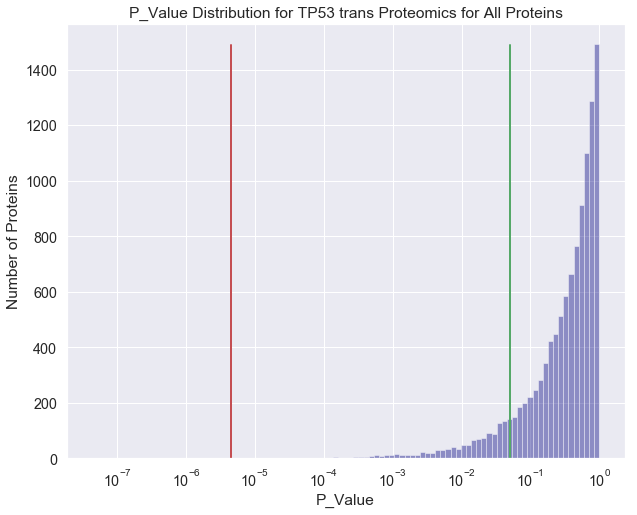

In [11]:
# Create series of p-values for Histogram
prot_pval_series = prot_all_comparisons['P_Value']

# Format figure size and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
prot_log_min, prot_log_max = np.log10(prot_pval_series.min()), np.log10(prot_pval_series.max())
prot_bins = np.logspace(prot_log_min - 1, prot_log_max, 100) # change bin number here
histogram = sns.distplot(prot_pval_series, bins = prot_bins, kde=False, color='navy') # bins 100 

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Proteomics for All Proteins")
histogram.set(ylabel = 'Number of Proteins')
#plt.xlim([10e-8,10e-1]) # change x-axis range
#plt.ylim([0, 3500]) # change y-axis range

# Graph cutoffs: alpha = green, bonferroni = red
plt.axvline(prot_bonferroni_cutoff, 0, 0.95, linewidth=2, color='r')
plt.axvline(0.05, 0, 0.95, linewidth=2, color='g')

plt.show()
plt.clf()
plt.close()

Proteomics zoomed in 

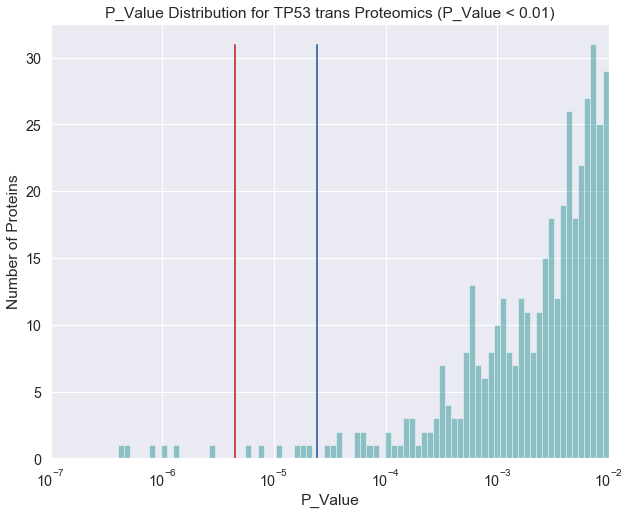

In [12]:
# Select p-values within range 0 - end_value 
prot_end_value = 0.01
prot_zoomed = prot_pval_series.loc[prot_pval_series <= prot_end_value]

# Format size of figure and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
zoomed_log_min, zoomed_log_max = np.log10(prot_zoomed.min()),np.log10(prot_zoomed.max())
prot_bins_zoomed = np.logspace(zoomed_log_min - 1, zoomed_log_max, 100) # change this number for more or less bins
histogram = sns.distplot(prot_zoomed, bins = prot_bins_zoomed, kde=False, color='teal')

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Proteomics (P_Value < " + str(prot_end_value) + ")")
histogram.set(ylabel = 'Number of Proteins')
plt.xlim([10e-8,10e-3]) # change x-axis range
#plt.ylim([0.0,20]) # change y axis intervals

# Create bonferroni cutoff line 
plt.axvline(prot_bonferroni_cutoff, 0, .95, linewidth=2, color='r') # cutoff line parameters: (cutoff, 0, height)

# cutoff for gsea
plt.axvline(prot_bonferroni_cutoff + .00002, 0, .95, linewidth=2, color='b') # cutoff line parameters: (cutoff, 0, height)

plt.show()
plt.clf()
plt.close()

In [13]:
# Gene set enrichment analysis for 50 genes
prot_gsea = prot_all_comparisons.sort_values(by = 'P_Value')
prot_first_fifty = prot_gsea.iloc[:50]
print("Number of Proteomics comparisons for gsea: ", len(prot_first_fifty))

# create gene list
prot_genes = prot_first_fifty['Comparison']
prot_genes.replace(to_replace = '_proteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
prot_genes_list = list(prot_genes)

prot_enr = gp.enrichr(gene_list = prot_genes_list, description='Proteomics_Comparisons', gene_sets='KEGG_2016', 
                       outdir='Enrichment Analysis')

prot_enr.res2d

Number of Proteomics comparisons for gsea:  50


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,p53 signaling pathway_Homo sapiens_hsa04115,6/69,1.903829e-08,0.000006,0,0,34.782609,618.323960,CASP9;CDK6;RRM2B;CDKN2A;TNFRSF10B;DDB2,KEGG_2016
1,Viral carcinogenesis_Homo sapiens_hsa05203,5/205,1.569324e-04,0.022991,0,0,9.756098,85.460443,CDK6;CDKN1B;CDKN2A;ACTN4;BAK1,KEGG_2016
2,Non-small cell lung cancer_Homo sapiens_hsa05223,3/56,3.712232e-04,0.036256,0,0,21.428571,169.258006,CASP9;CDK6;CDKN2A,KEGG_2016
3,Hepatitis B_Homo sapiens_hsa05161,4/146,4.835142e-04,0.035417,0,0,10.958904,83.664984,CASP9;CDK6;CDKN1B;DDB2,KEGG_2016
4,Pancreatic cancer_Homo sapiens_hsa05212,3/66,6.021466e-04,0.035286,0,0,18.181818,134.818358,CASP9;CDK6;CDKN2A,KEGG_2016
...,...,...,...,...,...,...,...,...,...,...
68,Epstein-Barr virus infection_Homo sapiens_hsa0...,1/202,3.984181e-01,1.000000,0,0,1.980198,1.822284,CDKN1B,KEGG_2016
69,Rap1 signaling pathway_Homo sapiens_hsa04015,1/211,4.119571e-01,1.000000,0,0,1.895735,1.681206,EPHA2,KEGG_2016
70,Ras signaling pathway_Homo sapiens_hsa04014,1/227,4.352931e-01,1.000000,0,0,1.762115,1.465614,EPHA2,KEGG_2016
71,HTLV-I infection_Homo sapiens_hsa05166,1/258,4.779526e-01,1.000000,0,0,1.550388,1.144564,CDKN2A,KEGG_2016


In [19]:
prot_enr.res2d[:20]

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,p53 signaling pathway_Homo sapiens_hsa04115,6/69,1.903829e-08,0.000006,0,0,34.782609,618.323960,CASP9;CDK6;RRM2B;CDKN2A;TNFRSF10B;DDB2,KEGG_2016
1,Viral carcinogenesis_Homo sapiens_hsa05203,5/205,1.569324e-04,0.022991,0,0,9.756098,85.460443,CDK6;CDKN1B;CDKN2A;ACTN4;BAK1,KEGG_2016
2,Non-small cell lung cancer_Homo sapiens_hsa05223,3/56,3.712232e-04,0.036256,0,0,21.428571,169.258006,CASP9;CDK6;CDKN2A,KEGG_2016
3,Hepatitis B_Homo sapiens_hsa05161,4/146,4.835142e-04,0.035417,0,0,10.958904,83.664984,CASP9;CDK6;CDKN1B;DDB2,KEGG_2016
4,Pancreatic cancer_Homo sapiens_hsa05212,3/66,6.021466e-04,0.035286,0,0,18.181818,134.818358,CASP9;CDK6;CDKN2A,KEGG_2016
5,Chronic myeloid leukemia_Homo sapiens_hsa05220,3/73,8.084333e-04,0.039478,0,0,16.438356,117.047875,CDK6;CDKN1B;CDKN2A,KEGG_2016
6,Small cell lung cancer_Homo sapiens_hsa05222,3/86,1.300254e-03,0.054425,0,0,13.953488,92.723659,CASP9;CDK6;CDKN1B,KEGG_2016
7,Pyrimidine metabolism_Homo sapiens_hsa00240,3/105,2.303789e-03,0.084376,0,0,11.428571,69.408000,UCK1;RRM2B;UCKL1,KEGG_2016
8,Cell cycle_Homo sapiens_hsa04110,3/124,3.686752e-03,0.120024,0,0,9.677419,54.222673,CDK6;CDKN1B;CDKN2A,KEGG_2016
9,Measles_Homo sapiens_hsa05162,3/136,4.773489e-03,0.139863,0,0,8.823529,47.158922,CDK6;CDKN1B;TNFRSF10B,KEGG_2016


# Phosphoproteomics: All Proteins

In [14]:
phos = 'phosphoproteomics'

try:
    print("\nGene: ", gene)

    # Create dataframe in order to do comparisons with wrap_ttest
    phosdf = brain.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=phos)
    phosdf = brain.reduce_multiindex(phosdf, flatten = True)
    phosdf = phosdf.loc[phosdf['Sample_Status'] == 'Tumor']
    
    #Remove Cis interactions
    phosdf = phosdf.loc[:,~phosdf.columns.str.contains(gene+'_phosphoproteomics')]
    phosdf = phosdf.dropna(axis=1, how='all') # drop columns with all NaN data
    
    
    # Create the binary valued column needed to do the comparison
    for ind, row in phosdf.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            phosdf.at[ind,'Label'] = 'Mutated'
        else:
            phosdf.at[ind,'Label'] = 'Wildtype'

    # Format the datafram correctly'''
    phosdf = phosdf.drop(gene+"_Mutation",axis=1)
    phosdf = phosdf.drop(gene+"_Location",axis=1)
    phosdf = phosdf.drop(gene+"_Mutation_Status", axis=1)
    phosdf = phosdf.drop("Sample_Status",axis=1)

    # Make list of columns to be compared using t-tests
    phos_col_list = list(phosdf.columns)
    phos_col_list.remove('Label')
    
    print("Doing t-test comparisons\n")
    
    #Call wrap_ttest, pass in formatted dataframe
    phos_all_comparisons = al.wrap_ttest(phosdf, 'Label', phos_col_list, return_all=True)
    
    phos_num_comparisons = len(phos_col_list)
    print("Number of comparisons:", phos_num_comparisons)
    phos_bonferroni_cutoff = .05 / phos_num_comparisons
    print("Bonferroni cutoff = ", phos_bonferroni_cutoff)
    print("Logged Bonferroni cutoff = ", phos_bonferroni_cutoff)
            
        
except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  TP53


Doing t-test comparisons

2 significant comparisons!
Number of comparisons: 101346
Bonferroni cutoff =  4.933593827087404e-07
Logged Bonferroni cutoff =  4.933593827087404e-07


Print Significant Comparisons

In [15]:
phos_all_comparisons = phos_all_comparisons.dropna(axis=0)
phos_sig_comparisons = phos_all_comparisons.loc[phos_all_comparisons['P_Value'] <= phos_bonferroni_cutoff]
print("Number of significant Phosphoproteomics comparisons: ", len(phos_sig_comparisons))
phos_sig_comparisons.head()

Number of significant Phosphoproteomics comparisons:  2


,Comparison,P_Value
0,TCEAL3_phosphoproteomics_S65_REDEGEPGDEGQLEDEG...,1.559019e-09
1,TCEAL3_phosphoproteomics_S72_QGRS*EGEGKPQGEGK_...,3.528867e-08


Phosphoproteomics Histograms

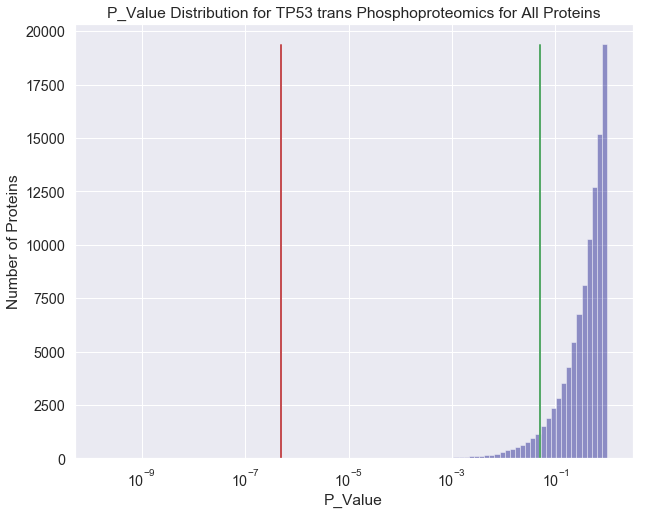

In [16]:
# Create series of p-values for Histogram
phos_pval_series = phos_all_comparisons['P_Value']

# Format figure size and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
phos_log_min, phos_log_max = np.log10(phos_pval_series.min()), np.log10(phos_pval_series.max())
phos_bins = np.logspace(phos_log_min - 1, phos_log_max, 100) # change bin number here
histogram = sns.distplot(phos_pval_series, bins = phos_bins, kde=False, color='navy') 

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Phosphoproteomics for All Proteins")
histogram.set(ylabel = 'Number of Proteins')
#plt.xlim([10e-10,10e-1]) # change x-axis range
#plt.ylim([0, 3500]) # change y-axis range

# Graph cutoffs: alpha = green, bonferroni = red
plt.axvline(phos_bonferroni_cutoff, 0, 0.95, linewidth=2, color='r')
plt.axvline(0.05, 0, 0.95, linewidth=2, color='g')

plt.show()
plt.clf()
plt.close()

Phosphoproteomics zoomed in

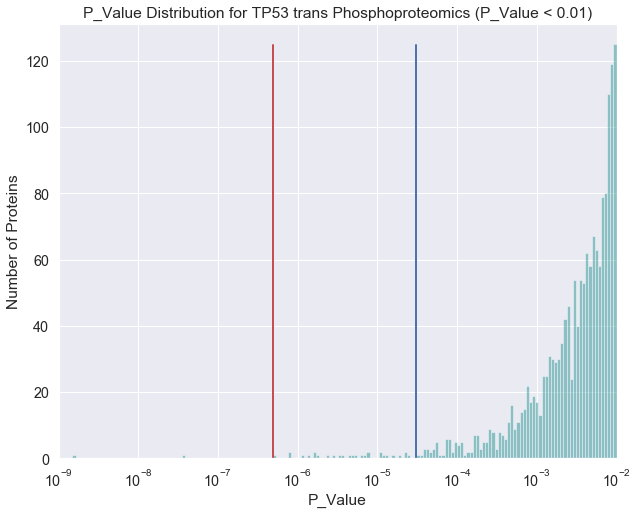

In [17]:
phos_pval_series = phos_all_comparisons['P_Value']
# Select p-values within range 0 - end_value 
phos_end_value = 0.01
phos_zoomed = phos_pval_series.loc[phos_pval_series <= phos_end_value]

# Format size of figure and font
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)

# Create log scale for the x-axis
plt.xscale('log')
phos_zoomed_log_min, phos_zoomed_log_max = np.log10(phos_zoomed.min()),np.log10(phos_zoomed.max())
phos_bins_zoomed = np.logspace(phos_zoomed_log_min - 1, phos_zoomed_log_max, 200) # change this number for more or less bins
histogram = sns.distplot(phos_zoomed, bins = phos_bins_zoomed, kde=False, color='teal')

# Format title and axis
histogram.set_title("P_Value Distribution for "+gene+" trans Phosphoproteomics (P_Value < " + str(phos_end_value) + ")")
histogram.set(ylabel = 'Number of Proteins')
plt.xlim([10e-10,10e-3]) # change x-axis range
#plt.ylim([0.0,20]) # change y axis intervals

# Create bonferroni cutoff line 
plt.axvline(phos_bonferroni_cutoff, 0, .95, linewidth=2, color='r') # cutoff line parameters: (cutoff, 0, height)

# Create bonferroni cutoff line 
plt.axvline(phos_bonferroni_cutoff + .00003, 0, .95, linewidth=2, color='b') # cutoff line parameters: (cutoff, 0, height)

plt.show()
plt.clf()
plt.close()

In [18]:
# Gene set enrichment analysis for 50 genes
phos_gsea = phos_all_comparisons.sort_values(by = 'P_Value')
phos_first_fifty = phos_gsea.iloc[:50]
print("Number of Phosphoproteomics comparisons for gsea: ", len(phos_first_fifty))

# create gene list
phos_genes = phos_gsea['Comparison']
phos_genes.replace(to_replace = '_phosphoproteomics.*$', value = '', 
                        inplace = True, regex = True) # shorten column names
phos_genes_list = list(phos_genes)

phos_enr = gp.enrichr(gene_list = phos_genes_list, description='Phosphoproteomics_Comparisons', gene_sets='KEGG_2016', 
                       outdir='Enrichment Analysis')

phos_enr.res2d.head()

Number of Phosphoproteomics comparisons for gsea:  50


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,Endocytosis_Homo sapiens_hsa04144,199/259,5.346590e-29,1.566551e-26,0,0,1.789542,116.496502,VPS29;TFRC;ZFYVE9;WIPF1;WIPF2;WIPF3;ARPC5L;CBL...,KEGG_2016
1,MAPK signaling pathway_Homo sapiens_hsa04010,179/255,8.066032e-19,1.181674e-16,0,0,1.634938,68.113911,ATF2;FGF1;ELK1;FGF2;CRKL;ELK4;RPS6KA4;RPS6KA3;...,KEGG_2016
2,Insulin signaling pathway_Homo sapiens_hsa04910,108/139,5.449858e-17,5.322695e-15,0,0,1.809662,67.768872,CALML5;IRS1;INPPL1;ARAF;CBLB;IRS2;ELK1;CRKL;PP...,KEGG_2016
3,Fc gamma R-mediated phagocytosis_Homo sapiens_...,78/93,3.976445e-16,2.912746e-14,0,0,1.953440,69.270901,NCF1;ARPC1B;ARPC1A;ARPC5L;INPPL1;PIK3CD;WASL;P...,KEGG_2016
4,Dopaminergic synapse_Homo sapiens_hsa04728,98/129,2.016737e-14,1.181808e-12,0,0,1.769395,55.797372,ATF2;CALML5;PPP2R2A;COMT;PPP1CB;PPP1CC;PPP2R1A...,KEGG_2016
